<a href="https://colab.research.google.com/github/hexaquarks/PHYS339/blob/main/LabFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
import numpy as np

SAMPLES = 3
callibrationInputs = list(range(0,4125,125))
callibrationInputs_error = [0 for x in range(len(callibrationInputs))]

callibrationOutputs = [[] for y in range(SAMPLES)] 
callibrationOutputsAmped = [[] for y in range(SAMPLES)] 

for i in range(SAMPLES) :
  with open(f'callibration12Bit_Trial{i+1}.txt', "r") as stream:
          for line in stream:
              currLine = line.split(" ")
              for j in range(len(currLine)-1):
                callibrationOutputs[i].append(float(currLine[j]))
  with open(f'callibrationAmped_Trial{i+1}.txt', "r") as stream:
          for line in stream:
              currLine = line.split(" ")
              for j in range(len(currLine)-1):
                callibrationOutputsAmped[i].append(float(currLine[j]))
                

def standardization (arr):
  arr_out =  [np.mean([x,y,z]) for x,y,z in zip(*arr)]
  arr_out_error =  [np.std([x,y,z]) for x,y,z in zip(*arr)]                                                          
  return arr_out,arr_out_error

callibrationOutputs, callibrationOutputs_error = standardization(callibrationOutputs)    
callibrationOutputsAmped, callibrationOutputsAmped_error = standardization(callibrationOutputsAmped)    

## Truncating data for better precision
callibrationInputs = callibrationInputs[3:]
callibrationInputs_error = callibrationInputs_error[3:]
callibrationOutputs = callibrationOutputs[3:]
callibrationOutputs_error = callibrationOutputs_error[3:]
callibrationOutputsAmped = callibrationOutputsAmped[1:]
callibrationOutputsAmped_error = callibrationOutputsAmped_error[1:]

In [181]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import linspace,polyfit, diag,sqrt
from numpy import log as ln
from scipy.optimize import curve_fit

def linearizedFit(x, y, y_error):
     popt, pcov = polyfit(
     x,
     y,
     1,
     w=[1 / (error+1) for error in y_error],
     cov=True,
     )
     perr = sqrt(diag(pcov))
     return popt, perr

def linearFitResiduals(x, x_error, m, m_error, b, b_error):
     y = m * x + b
     y_error = b_error + sqrt(
     (x * m_error) ** 2  + (m * x_error) ** 2)
     return y, y_error
 
def residual(x, x_error, y, y_error, m, m_error, b, b_error):
     y_fit, y_fit_error = linearFitResiduals(x, x_error, m, m_error, b, b_error)
     return y - y_fit, y_error + y_fit_error 
 
def chiSquared(ys, ys_error, fit_ys):
     return sum([
         ((y - fit_y) / y_error) ** 2
         for y, y_error, fit_y in zip(ys, ys_error, fit_ys)
     ])
 
def linearFit(x, m, b):
 return m*x + b

def linearFitError(x, m, m_error, b, b_error):
 return sqrt((x*m_error)**2 + b_error**2)


In [182]:
(m_cal, b_cal), \
(m_cal_error, b_cal_error)= \
linearizedFit(callibrationInputs, callibrationOutputs, callibrationOutputs_error)

(m_cal_amped, b_cal_amped), \
(m_cal_amped_error, b_cal_amped_error)= \
linearizedFit(callibrationInputs, callibrationOutputsAmped, callibrationOutputsAmped_error)

print(m_cal)
print(m_cal_error)
print(b_cal)
print(b_cal_error)
print("---")
print(m_cal_amped)
print(m_cal_amped_error)
print(b_cal_amped)
print(b_cal_amped_error)

0.0011874671897609827
4.032331013955763e-07
0.29504962080358726
0.000983871376754589
---
0.004552575636507729
1.5866156087007847e-06
-1.135801261211778
0.003856794636678475


## Plotting

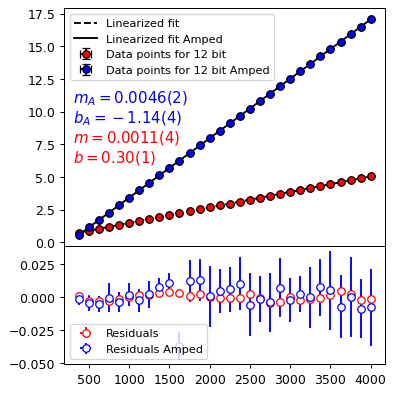

In [183]:
import matplotlib.pyplot as plt

fig, (a0, a1) = plt.subplots(
     2,
     1,
     gridspec_kw={
     "height_ratios": [2, 1],
     "hspace": 0,
     },
     figsize=(4.5,4.5),
     dpi=90
)

fit = [linearFit(x, m_cal , b_cal) for x in callibrationInputs]
fitAmped = [linearFit(x, m_cal_amped , b_cal_amped) for x in callibrationInputs]

a0.errorbar(
    x=callibrationInputs,
    y=callibrationOutputs,
    xerr = callibrationInputs_error,
    yerr = callibrationOutputs_error,
    fmt='ro', ecolor="black",mec="black", capsize=3,
    label = "Data points for 12 bit")

a0.errorbar(
    x=callibrationInputs,
    y=callibrationOutputsAmped,
    xerr = callibrationInputs_error,
    yerr = callibrationOutputsAmped_error,
    fmt='bo', ecolor="black",mec="black", capsize=3,
    label = "Data points for 12 bit Amped")

a0.plot(
    callibrationInputs,
    fit,
    '--',
    color='black',
    label="Linearized fit")

a0.plot(
    callibrationInputs,
    fitAmped,
    '-',
    color='black',
    label="Linearized fit Amped")

#residual ploting
residuals, residuals_error = [
     list(values)
     for values in zip(*[
             residual(x, x_error, y, y_error, m_cal, m_cal_error, b_cal, b_cal_error)
             for x, x_error, y, y_error in zip(
                     callibrationInputs, callibrationInputs_error,
                     callibrationOutputs, callibrationOutputs_error
             )
     ])
]

residualsAmped, residualsAmped_error = [
     list(values)
     for values in zip(*[
             residual(x, x_error, y, y_error, m_cal_amped, m_cal_amped_error, b_cal_amped, b_cal_amped_error)
             for x, x_error, y, y_error in zip(
                     callibrationInputs, callibrationInputs_error,
                     callibrationOutputsAmped, callibrationOutputsAmped_error
             )
     ])
]

a1.errorbar(
     callibrationInputs,
     residuals,
     xerr=callibrationInputs_error,
     yerr=residuals_error,
     fmt="r.",
     marker="o",
     markerfacecolor="white",
     label="Residuals",
     color= "red"
)

a1.errorbar(
     callibrationInputs,
     residualsAmped,
     xerr=callibrationInputs_error,
     yerr=residualsAmped_error,
     fmt="b.",
     marker="o",
     markerfacecolor="white",
     label="Residuals Amped",
     color= "red"
)

## plot annotation
0.004552575636507729
1.5866156087007847e-06
-1.135801261211778
0.003856794636678475
a0.text(300, 11.0, r"$m_A = 0.0046(2)$", horizontalalignment='left', 
          verticalalignment='center', fontsize=12, color="blue")
a0.text(300, 9.5, r"$b_A = - 1.14(4)$", horizontalalignment='left', 
          verticalalignment='center', fontsize=12, color="blue")
a0.text(300, 8.0, r"$m = 0.0011(4)$", horizontalalignment='left', 
          verticalalignment='center', fontsize=12, color="red")
a0.text(300, 6.5, r"$b = 0.30(1)$", horizontalalignment='left', 
          verticalalignment='center', fontsize=12, color="red")

a0.legend(loc="upper left", fontsize=9)
a1.legend(loc="lower left", fontsize=9)
fig.tight_layout()


In [184]:
import numpy as np

SAMPLES = 5
measuringSaltInputs = list(range(0,4100,10))
measuringSaltInputs_error = [0 for x in range(len(measuringSaltInputs))]

measuringSaltOutputs = [[] for y in range(SAMPLES)] 

for i in range(SAMPLES) :
  with open(f'MeasuringSalt_Trial{i+1}' + ("_HIGH" if i == 4 else "") + '.txt', "r") as stream:
          for line in stream:
              currLine = line[10:].split(",")
              measuringSaltOutputs[i].append(float(currLine[1]))


## Converting Input values from 12 bit to Voltage

In [185]:
measuringSaltOutputsError = [0 for x in range(len(measuringSaltOutputs[0]))]

def convertToVolt(x, x_error): 
  return m_cal * x + b_cal

def convertToVoltError(x, x_error): 
  return sqrt((x * m_cal_error)**2 + (b_cal_error)**2)

measuringSaltInputsConverted = [convertToVolt(x, x_error) for x, x_error in 
                                             zip(measuringSaltInputs, measuringSaltInputs_error)]
measuringSaltInputsConvertedError = [convertToVoltError(x, x_error) for x, x_error in 
                                             zip(measuringSaltInputs, measuringSaltInputs_error)]                                             
                                                     

## Convert Output values to 10 bit, then to current

In [186]:
m_10bit, m_10bit_error = 0.00491, 0.00001 #from last lab
b_10bit, b_10bit_error = 0.0486, 0.0007 #from last lab

### Convert 10 bit to voltage
def convert10BitToVolt(x, x_error): 
  return m_10bit * x + b_10bit

def convert10BitToVoltError(x, x_error): 
  return sqrt((x * m_10bit_error)**2 + (b_10bit_error)**2)

measuringSaltOutputsConverted = [[convert10BitToVolt(x, x_error) for x, x_error in 
                                             zip(measuringSaltOutputs[i], measuringSaltOutputsError)] 
                                 for i in range(SAMPLES)]                     
measuringSaltOutputsConvertedError = [[convert10BitToVoltError(x, x_error) for x, x_error in 
                                             zip(measuringSaltOutputs[i], measuringSaltOutputsError)] 
                                 for i in range(SAMPLES)]    

### Convert Voltage to current
R = 993
R_error = 1

def convertToCurrent(V, V_error):
  return V / R

def convertToCurrentError(V, V_error):
  return sqrt(((1/R)*V_error)**2 + ((V*R_error)/R**2)**2)

currentOutput = [[convertToCurrent(x, x_error) for x, x_error in 
                  zip(measuringSaltOutputsConverted[i], measuringSaltOutputsConvertedError[i])] 
                 for i in range(SAMPLES)]
currentOutputError = [[convertToCurrentError(x, x_error) for x, x_error in 
                  zip(measuringSaltOutputsConverted[i], measuringSaltOutputsConvertedError[i])] 
                for i in range(SAMPLES)]          

In [187]:
def calculateResistance(m, m_error):
  R = 1/m 
  R_error = sqrt((1/m**2) * m_error)
  return [R,R_error]

## Plotting

1.1230266470358123
1.0858572411072525
1.075728312294308
1.0889861120991304
1.0546632660951512
0.051162753862382844
0.03682341390743479
0.028719572772756184
0.04206699678779748
0.03053878797435907


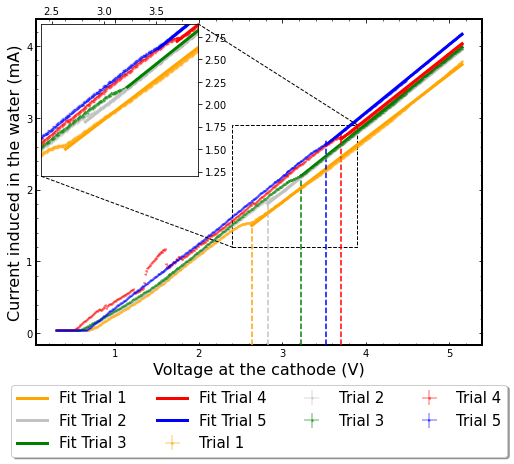

In [177]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from numpy import linspace
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d

FIGURE_COLORS = ["orange" , "#C2C2C2", "green", "red", "blue"]    
MARKER_SHAPE = ["o", "v", "^", "<", ">"]
LABEL = ["Trial 1","Trial 2","Trial 3","Trial 4","Trial 5"]
fitParams = [2.6343599846327233, 2.8243547349944804, 3.2280935795132146, 
             3.703080455417608, 3.5249603769534605]
fitResistances = []

fig, ax = plt.subplots(figsize=[8, 6])

# plotting the zoom inset
axins = zoomed_inset_axes(ax,1.25,loc="upper left")

for i in range(SAMPLES):
  ## the original error bar
  ax.errorbar(
      x=measuringSaltInputsConverted,
      y=measuringSaltOutputsConverted[i],
      xerr = measuringSaltInputsConvertedError,
      yerr = measuringSaltOutputsConvertedError[i],
      fmt=MARKER_SHAPE[i], color=FIGURE_COLORS[i], label=LABEL[i],ms=2, 
      alpha=0.4)
  
  ## zoomed inset axes
  axins.errorbar(
      x=measuringSaltInputsConverted,
      y=measuringSaltOutputsConverted[i],
      xerr = measuringSaltInputsConvertedError,
      yerr = measuringSaltOutputsConvertedError[i],
      fmt=MARKER_SHAPE[i], color=FIGURE_COLORS[i], ms=3,
      alpha=0.4, zorder=-100)
  
  ## v-lines
  lineEnd = measuringSaltOutputsConverted[i][measuringSaltInputsConverted.index(fitParams[i])]
  ax.axvline(x=fitParams[i],ymin=0, ymax=(lineEnd/4.2), linestyle='--',color=FIGURE_COLORS[i])
  # axins.axvline(x=fitParams[i],ymin=0, ymax=(lineEnd/4.1)/1.25, linestyle='--',color=FIGURE_COLORS[i])

  ## Parameters to perform linear fit and resistance calculation
  fitIndex = measuringSaltInputsConverted.index(fitParams[i])
  tempInputs = measuringSaltInputsConverted[fitIndex:]
  tempOutputs = measuringSaltOutputsConverted[i][fitIndex:]
  tempOutputsError = measuringSaltOutputsConvertedError[i][fitIndex:]
  xLinspace = linspace(fitParams[i], measuringSaltInputsConverted[-1], 100)
  popt, perr = linearizedFit(tempInputs, tempOutputs, tempOutputsError)
  fitResistances.append(calculateResistance(popt[0], perr[0]))
  fit_ys = [linearFit(x, popt[0], popt[1]) for x in xLinspace]

  ## plot the linear fit
  ax.plot(xLinspace, fit_ys, linewidth=3, color = FIGURE_COLORS[i], linestyle='-',
          label=f'Fit ' + f'{LABEL[i]}')
  axins.plot(xLinspace, fit_ys,  linewidth=3, color = FIGURE_COLORS[i], linestyle='-')

  
ax.set_xlabel('Voltage at the cathode (V)', fontsize=16)
ax.set_ylabel('Current induced in the water (mA)', fontsize = 16)

ax.legend(loc="lower right", fontsize=9.5)

for ax in [ax]:
  ax.patch.set_edgecolor('black')  
  ax.patch.set_linewidth('2') 
  # ax.grid(b=True, which='major', color='black', alpha=0.4, linestyle='-')
  # ax.grid(b=True, which='minor', axis='x', color='black', linestyle='-', alpha=0.1)
  ax.minorticks_on()


x1,x2,y1,y2 = 2.4, 3.9, 1.2, 2.9

axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)
axins.xaxis.tick_top()
mark_inset(ax,axins,loc1=3,loc2=1, linewidth=1, linestyle='--')
axins.yaxis.tick_right()

## Plotting maximum occuring line
# ax.axvline(x=130,ymin=0, ymax=(maxValue/(850/650)), linestyle='--',color="red")
# axins.axvline(x=130, linestyle='--',color="red")

## ticks 
ax.tick_params(axis='y',which='both',
               direction="in",right=True)
ax.tick_params(axis='x', which='both',
               direction="in", top=True,bottom=True)

## legend
legend = ax.legend()
legend.get_frame().set_linewidth(1.7)
legend.get_frame().set_edgecolor("black")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=4, fancybox=True, shadow=True, fontsize=15)
# plt.show()

print(fitResistances[0][0])
print(fitResistances[1][0])
print(fitResistances[2][0])
print(fitResistances[3][0])
print(fitResistances[4][0])


print(fitResistances[0][1])
print(fitResistances[1][1])
print(fitResistances[2][1])
print(fitResistances[3][1])
print(fitResistances[4][1])

## For the Amped Experiment

In [178]:
import numpy as np

SAMPLES = 5
measuringSaltOutputsAmped = [[] for y in range(SAMPLES)] 

for i in range(SAMPLES) :
  with open(f'Trial{i+1}' + ("_NoSalt_NoObservation_Amped" if i == 0 
                             else "_MeasuringSalt_Amped") + '.txt', "r") as stream:
          for line in stream:
              currLine = line[10:].split(",")
              measuringSaltOutputsAmped[i].append(float(currLine[1]))

## Truncating data
measuringSaltInputsConverted = measuringSaltInputsConverted[:250]
measuringSaltInputsConvertedError = measuringSaltInputsConvertedError[:250]
measuringSaltOutputsAmped = [ measuringSaltOutputsAmped[i][:250] for i in range(len(measuringSaltOutputsAmped))]
measuringSaltOutputsAmpedError = measuringSaltOutputsAmped[:250]


## Converting 10 bit output to voltage, then to current

In [179]:
### Convert 10 bit to voltage
measuringSaltOutputsAmpedError = [0 for x in range(len(measuringSaltOutputsAmped[0]))]

def convert10BitToVolt(x, x_error): 
  return m_cal_amped * x + b_cal_amped

def convert10BitToVoltError(x, x_error): 
  return sqrt((x * m_cal_amped_error)**2 + (b_cal_amped_error)**2)

measuringSaltOutputsAmpedConverted = [[convert10BitToVolt(x, x_error) for x, x_error in 
                                             zip(measuringSaltOutputsAmped[i], measuringSaltOutputsAmpedError)] 
                                 for i in range(SAMPLES)]                     
measuringSaltOutputsAmpedConvertedError = [[convert10BitToVoltError(x, x_error) for x, x_error in 
                                             zip(measuringSaltOutputsAmped[i], measuringSaltOutputsAmpedError)] 
                                 for i in range(SAMPLES)]    

### Convert Voltage to current
R = 993
R_error = 1

def convertToCurrent(V, V_error):
  return V / R

def convertToCurrentError(V, V_error):
  return sqrt(((1/R)*V_error)**2 + ((V*R_error)/R**2)**2)

currentOutputAmped = [[convertToCurrent(x, x_error) for x, x_error in 
                  zip(measuringSaltOutputsAmpedConverted[i], measuringSaltOutputsAmpedConvertedError[i])] 
                 for i in range(SAMPLES)]
currentOutputAmpedError = [[convertToCurrentError(x, x_error) for x, x_error in 
                  zip(measuringSaltOutputsAmpedConverted[i], measuringSaltOutputsAmpedConvertedError[i])] 
                for i in range(SAMPLES)]          

In [188]:
## Slice the data for equal ending point
endIndex = measuringSaltInputsConverted.index(2.254370483909209)
measuringSaltInputsConverted = measuringSaltInputsConverted[0:endIndex]
measuringSaltInputsConvertedError = measuringSaltInputsConvertedError[0:endIndex]
measuringSaltOutputsAmpedConverted = [measuringSaltOutputsAmpedConverted[i][0:endIndex] for i in range(SAMPLES)]
measuringSaltOutputsAmpedConvertedError = [measuringSaltOutputsAmpedConvertedError[i][0:endIndex]for i in range(SAMPLES)]

# measuringSaltOutputsAmpedConverted = [[x + 1 for x in measuringSaltOutputsAmpedConverted[i]] 
#                                       for i in len(range(measuringSaltOutputsAmpedConverted))]



## Plotting

0.6043332382225147
0.4240099123725187
0.40087475469221107
0.39012047261091287
0.05220072291917958
0.014362882682270851
0.027117552924606405
0.02777959494870935


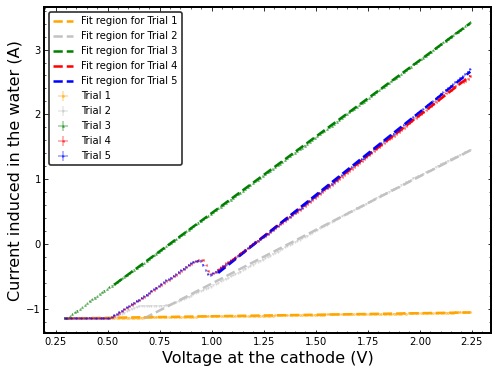

In [189]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from numpy import linspace
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d

FIGURE_COLORS = ["orange" , "#C2C2C2", "green", "red", "blue"]    
MARKER_SHAPE = ["o", "v", "^", "<", ">"]
LABEL = ["Trial 1","Trial 2","Trial 3","Trial 4","Trial 5"]
# fitParams = [0.29504962080358726, 0.6750391215271017, 
#              1.0312792784553966, 0.5325430587557838, 1.0312792784553966]
fitParams = [0.29504962080358726, 0.6750391215271017, 0.5325430587557838, 1.0312792784553966, 
             1.0312792784553966]
fitResistancesAmped = []

fig, ax = plt.subplots(figsize=[8, 6])

# plotting the zoom inset
# axins = zoomed_inset_axes(ax,1.25,loc="upper left")

for i in range(SAMPLES):
  ## the original error bar
  ax.errorbar(
      x=measuringSaltInputsConverted,
      y=measuringSaltOutputsAmpedConverted[i],
      xerr = measuringSaltInputsConvertedError,
      yerr = measuringSaltOutputsAmpedConvertedError[i],
      fmt=MARKER_SHAPE[i], color=FIGURE_COLORS[i], label=LABEL[i],ms=2, 
      alpha=0.4)
  
  ## zoomed inset axes
  # axins.errorbar(
  #     x=measuringSaltInputsConverted,
  #     y=measuringSaltOutputsAmpedConverted[i],
  #     xerr = measuringSaltInputsConvertedError,
  #     yerr = measuringSaltOutputsAmpedConvertedError[i],
  #     fmt=MARKER_SHAPE[i], color=FIGURE_COLORS[i], ms=3,
  #     alpha=0.4, zorder=-100)
  
  # v-lines
  lineEnd = measuringSaltOutputsAmpedConverted[i][measuringSaltInputsConverted.index(fitParams[i])]
  ax.axvline(x=fitParams[i],ymin=0, ymax=(lineEnd/3.7), linestyle='--',color=FIGURE_COLORS[i])
  # axins.axvline(x=fitParams[i],ymin=0, ymax=(lineEnd/4.1)/1.25, linestyle='--',color=FIGURE_COLORS[i])

  # Parameters to perform linear fit and resistance calculation
  fitIndex = measuringSaltInputsConverted.index(fitParams[i])
  tempInputs = measuringSaltInputsConverted[fitIndex:]
  tempOutputs = measuringSaltOutputsAmpedConverted[i][fitIndex:]
  tempOutputsError = measuringSaltOutputsAmpedConvertedError[i][fitIndex:]
  xLinspace = linspace(fitParams[i], measuringSaltInputsConverted[-1], 100)
  popt, perr = linearizedFit(tempInputs, tempOutputs, tempOutputsError)
  fitResistancesAmped.append(calculateResistance(popt[0], perr[0]))
  fit_ys = [linearFit(x, popt[0], popt[1]) for x in xLinspace]

  ## plot the linear fit
  ax.plot(xLinspace, fit_ys, linewidth=2.5, color = FIGURE_COLORS[i], linestyle='--',
          label=f'Fit region for ' + f'{LABEL[i]}')
  # axins.plot(xLinspace, fit_ys,  linewidth=2.5, color = FIGURE_COLORS[i], linestyle='--')

  
ax.set_xlabel('Voltage at the cathode (V)', fontsize=16)
ax.set_ylabel('Current induced in the water (A)', fontsize = 16)

ax.legend(loc="lower right", fontsize=9.5)

for ax in [ax]:
  ax.patch.set_edgecolor('black')  
  ax.patch.set_linewidth('2') 
  # ax.grid(b=True, which='major', color='black', alpha=0.4, linestyle='-')
  # ax.grid(b=True, which='minor', axis='x', color='black', linestyle='-', alpha=0.1)
  ax.minorticks_on()


# x1,x2,y1,y2 = 2.4, 3.9, 1.2, 2.9

# axins.set_xlim(x1,x2)
# axins.set_ylim(y1,y2)
# axins.xaxis.tick_top()
# mark_inset(ax,axins,loc1=3,loc2=1, linewidth=1, linestyle='--')
# axins.yaxis.tick_right()

## Plotting maximum occuring line
# ax.axvline(x=130,ymin=0, ymax=(maxValue/(850/650)), linestyle='--',color="red")
# axins.axvline(x=130, linestyle='--',color="red")

## ticks 
ax.tick_params(axis='y',which='both',
               direction="in",right=True)
ax.tick_params(axis='x', which='both',
               direction="in", top=True,bottom=True)

## legend
legend = ax.legend()
legend.get_frame().set_linewidth(1.7)
legend.get_frame().set_edgecolor("black")
# plt.show()

# print(fitResistancesAmped[0][0])
print(fitResistancesAmped[1][0])
print(fitResistancesAmped[2][0])
print(fitResistancesAmped[3][0])
print(fitResistancesAmped[4][0])

# print(fitResistancesAmped[0][1])
print(fitResistancesAmped[1][1])
print(fitResistancesAmped[2][1])
print(fitResistancesAmped[3][1])
print(fitResistancesAmped[4][1])

## Calculating salinity concentration

In [190]:
def massToSalinity(m, m_error, volume, volume_error): 
  return m/volume

def massToSalinityError(m, m_error, volume, volume_error):
  return np.sqrt((m_error/volume)**2 + ((m*volume_error)/volume)**2)

volume90, volume90Error = 0.09, 0.01
volume100, volume100Error = 0.1, 0.01


mass5Volt = [0.0000, 0.0139, 0.1448, 0.1706, 0.8615]
mass18Volt = [0.0534, 0.0935, 0.1336, 0.1813]
mass5VoltError = [0.0001 for x in range(len(mass5Volt))]
mass18VoltError = [0.0001 for x in range(len(mass18Volt))]

concentration5Volt = [massToSalinity(mass5Volt[i], mass5VoltError[i], volume90, volume90Error) 
                      for i in range(len(mass5Volt))]
concentration18Volt = [massToSalinity(mass18Volt[i], mass18VoltError[i], volume100, volume100Error) 
                      for i in range(len(mass18Volt))]
concentration5VoltError = [massToSalinityError(mass5Volt[i], mass5VoltError[i], volume90, volume90Error) 
                      for i in range(len(mass5Volt))]
concentration18VoltError = [massToSalinityError(mass18Volt[i], mass18VoltError[i], volume100, volume100Error) 
                      for i in range(len(mass18Volt))]


## Final Plots

In [191]:
resistances5Volt = []
resistances5VoltError = []
resistances18Volt = []
resistances18VoltError = []

for i in range(5):
  resistances5Volt.append(fitResistances[i][0])
  resistances5VoltError.append(fitResistances[i][1])

for i in range(5):
  if i == 0: continue
  resistances18Volt.append(fitResistancesAmped[i][0])
  resistances18VoltError.append(fitResistancesAmped[i][1]) 

(m_5Vresistance, b_5Vresistance), \
(m_5Vresistance_error, b_5Vresistance_error)= \
linearizedFit(concentration5Volt, resistances5Volt, resistances5VoltError)

(m_18Vresistance, b_18Vresistance), \
(m_18Vresistance_error, b_18Vresistance_error)= \
linearizedFit(concentration18Volt, resistances18Volt, resistances18VoltError)

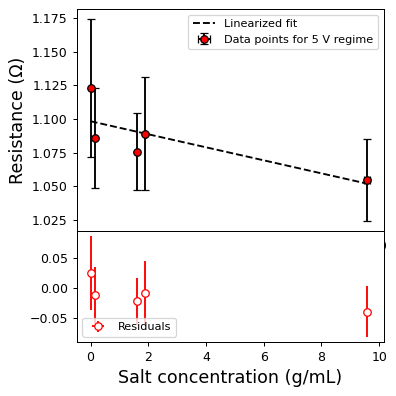

In [192]:
import matplotlib.pyplot as plt

fig, (a0, a1) = plt.subplots(
     2,
     1,
     gridspec_kw={
     "height_ratios": [2, 1],
     "hspace": 0,
     },
     figsize=(4.5,4.5),
     dpi=90
)

fit5Volt = [linearFit(x, m_5Vresistance , b_5Vresistance) for x in concentration5Volt]

a0.errorbar(
    x=concentration5Volt,
    y=resistances5Volt,
    xerr = concentration5VoltError,
    yerr = resistances5VoltError,
    fmt='ro', ecolor="black",mec="black", capsize=3,
    label = "Data points for 5 V regime")

a0.plot(
    concentration5Volt,
    fit5Volt,
    '--',
    color='black',
    label="Linearized fit")

#residual ploting
residuals5Volt, residuals5Volt_error = [
     list(values)
     for values in zip(*[
             residual(x, x_error, y, y_error, m_5Vresistance, m_5Vresistance_error, b_5Vresistance, b_5Vresistance_error)
             for x, x_error, y, y_error in zip(
                     mass5Volt, mass5VoltError,
                     resistances5Volt, resistances5VoltError
             )
     ])
]

a1.errorbar(
     concentration5Volt,
     residuals5Volt,
     xerr=concentration5VoltError,
     yerr=residuals5Volt_error,
     fmt="r.",
     marker="o",
     markerfacecolor="white",
     label="Residuals",
     color= "red"
)
a1.set_xlabel('Salt concentration (g/mL)', fontsize=14)
a0.set_ylabel('Resistance (Ω)', fontsize = 14)
## plot annotation
# a0.text(300, 11.0, r"$m_A = 0.0046(2)$", horizontalalignment='left', 
#           verticalalignment='center', fontsize=12, color="blue")
# a0.text(300, 9.5, r"$b_A = - 1.14(4)$", horizontalalignment='left', 
#           verticalalignment='center', fontsize=12, color="blue")


a0.legend(loc="upper right", fontsize=9)
a1.legend(loc="lower left", fontsize=9)
fig.tight_layout()


0.534
0.9349999999999999
1.3359999999999999
1.8129999999999997
---
0.0054328261521974
0.009403323880415903
0.01339737287679939
0.018157557655147344


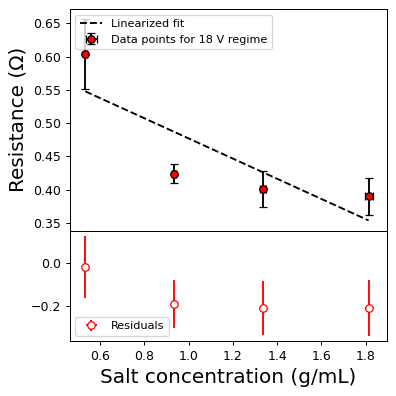

In [193]:
import matplotlib.pyplot as plt

fig, (a0, a1) = plt.subplots(
     2,
     1,
     gridspec_kw={
     "height_ratios": [2, 1],
     "hspace": 0,
     },
     figsize=(4.5,4.5),
     dpi=90
)

fit18Volt = [linearFit(x, m_18Vresistance , b_18Vresistance) for x in concentration18Volt]

a0.errorbar(
    x=concentration18Volt,
    y=resistances18Volt,
    xerr = concentration18VoltError,
    yerr = resistances18VoltError,
    fmt='ro', ecolor="black",mec="black", capsize=3,
    label = "Data points for 18 V regime")

a0.plot(
    concentration18Volt,
    fit18Volt,
    '--',
    color='black',
    label="Linearized fit")

#residual ploting
residuals18Volt, residuals18Volt_error = [
     list(values)
     for values in zip(*[
             residual(x, x_error, y, y_error, m_18Vresistance, m_18Vresistance_error, b_18Vresistance, b_18Vresistance_error)
             for x, x_error, y, y_error in zip(
                     mass18Volt, mass18VoltError,
                     resistances18Volt, resistances18VoltError
             )
     ])
]

a1.errorbar(
     concentration18Volt,
     residuals18Volt,
     xerr=concentration18VoltError,
     yerr=residuals18Volt_error,
     fmt="r.",
     marker="o",
     markerfacecolor="white",
     label="Residuals",
     color= "red"
)

a1.set_xlabel('Salt concentration (g/mL)', fontsize=16)
a0.set_ylabel('Resistance (Ω)', fontsize = 16)

## plot annotation
# a0.text(300, 11.0, r"$m_A = 0.0046(2)$", horizontalalignment='left', 
#           verticalalignment='center', fontsize=12, color="blue")
# a0.text(300, 9.5, r"$b_A = - 1.14(4)$", horizontalalignment='left', 
#           verticalalignment='center', fontsize=12, color="blue")


a0.legend(loc="upper left", fontsize=9)
a1.legend(loc="lower left", fontsize=9)
fig.tight_layout()



print(concentration18Volt[0])
print(concentration18Volt[1])
print(concentration18Volt[2])
print(concentration18Volt[3])
print("---")
print(concentration18VoltError[0])
print(concentration18VoltError[1])
print(concentration18VoltError[2])
print(concentration18VoltError[3])